# make long ts

### look at all_spk_lts.txt

this is the normalized pitch version, all speaker

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [346]:
#normal version
lts=open('all_spk_lts.txt','r').read().split('\n')
lts=[float(i) for i in lts[:-1]]
print len(lts)

17654651


In [12]:
#interjection version
ltsj=open('all_spk_lts_interj.txt','r').read().split('\n')
ltsj=[float(i) for i in ltsj[:-1]]
print len(ltsj)

19550616


### normal version variable length

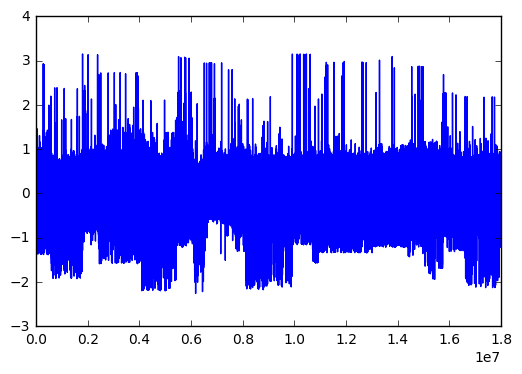

In [7]:
plt.plot(lts)#original version

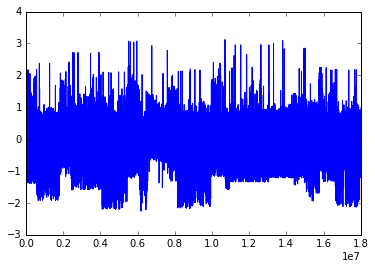

In [243]:
plt.plot(lts)#this is first newly trimmed version

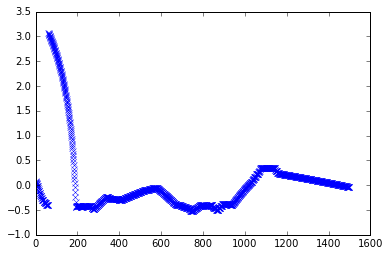

In [266]:
plt.plot(lts[int(0.5*1e7)+400000+122500:int(0.6*1e7)-400000-70000-6000],'x')

In [267]:
int(0.5*1e7)+400000+122500

5522500

In [353]:
#a=[1 for i in range(len(lts))]

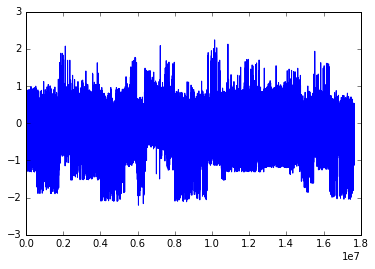

In [347]:
#third trimmed version (no extrapolation + two-stage trimming)
plt.plot(lts)

# play with speaker pitch distribution to filter spurious pitch

In [359]:
from os import listdir
import numpy as np
from downsample import *
import random
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

def get_speaker_mean(speaker,path):
    """path contains all pitch files, and we'll pick out files for this speaker to normalize"""
    onlyfiles = [ f for f in listdir(path) if f.startswith(speaker) and f.endswith('.tab')]
    all_pitch=[]
    for file_pitch in onlyfiles:
        time,pitch=get_vec_noext(path+file_pitch)

        pitch_float=[float(i) for i in pitch]
        pitch_log=np.log2(pitch_float)
        all_pitch.extend(pitch_log[:])
    return all_pitch,np.mean(all_pitch)


def normalize(pitch,spk_mean):
    """let's normalize one file for now"""
    #normalize,log,downsample,smooth
    #for this speaker, normalize all files of this spk
    #print pitch[:100],'here'
    pitch_float=[float(i) for i in pitch]
    pitch=np.array(pitch_float)
    log_pitch=np.log2(pitch)
    norm_pitch=(log_pitch-spk_mean)/np.std(log_pitch)
    #log_pitch=np.log(norm_pitch)
    #down_pitch=downsample_mix(log_pitch,30)
    return norm_pitch





def get_all_speaker(train_path):
    
    onlyfiles = [ f for f in listdir(train_path) if f.endswith(".flac")]
    all_speaker=set()
    for file_sound in onlyfiles:
        speaker=file_sound[:3]
        if speaker not in all_speaker:
            all_speaker.add(speaker)
    return all_speaker


def get_vec_noext(file):
    """don't get extrapolated values"""
    time=[]
    pitch=[]
    f=open(file,'r').read().split('\n')
    #print 'line number:',len(f)
    for line in f[1:]:
        if line!='':
            l=line.split('\t')
            if float(l[1])!=1000:
                time.append(l[0])
                pitch.append(l[1])
    return time,pitch



def test_plot(pitch):
    x = np.linspace(0,30, len(pitch))
    plt.plot(x, pitch, 'bo-')
    plt.show()





In [ ]:
i

loading speaker mean...
loading speaker mean...
loading speaker mean...
loading speaker mean...
loading speaker mean...
loading speaker mean...
loading speaker mean...
loading speaker mean...
loading speaker mean...
loading speaker mean...
loading speaker mean...
loading speaker mean...
loading speaker mean...
loading speaker mean...
loading speaker mean...
loading speaker mean...
loading speaker mean...
loading speaker mean...
loading speaker mean...
loading speaker mean...


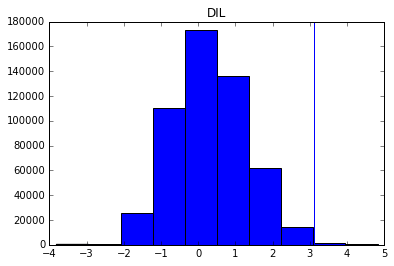

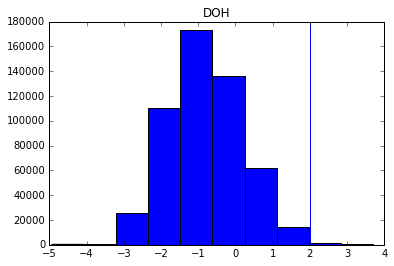

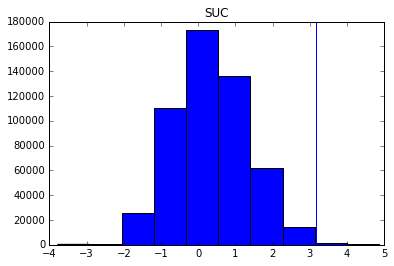

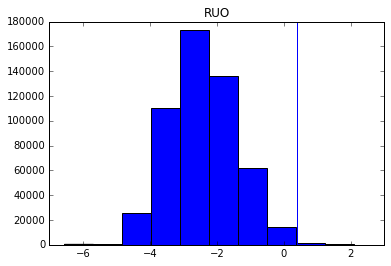

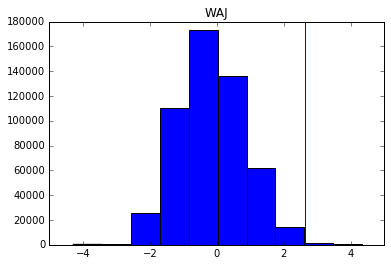

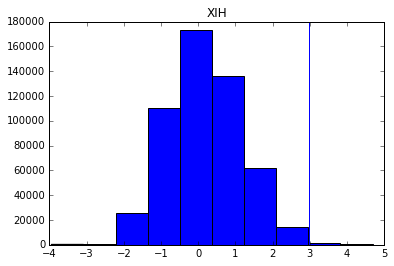

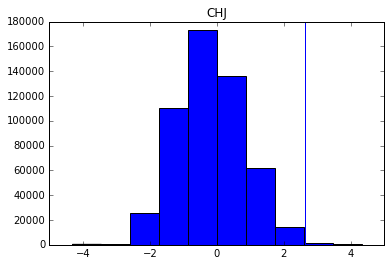

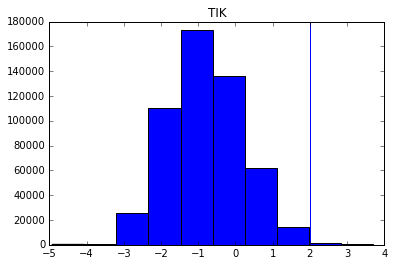

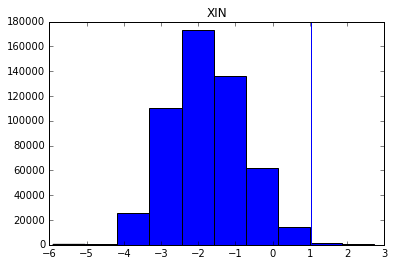

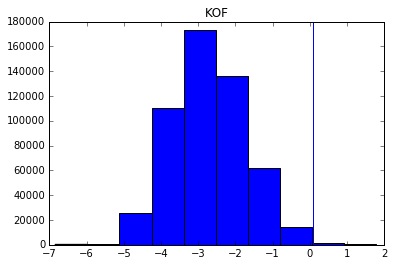

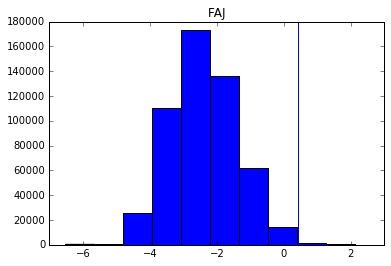

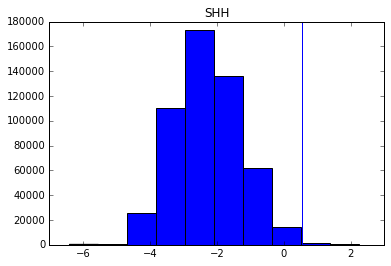

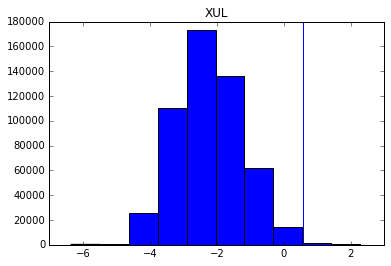

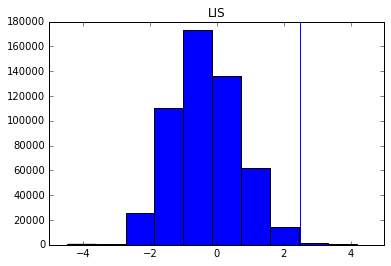

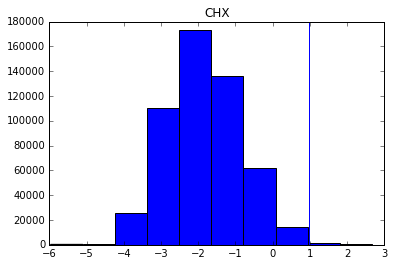

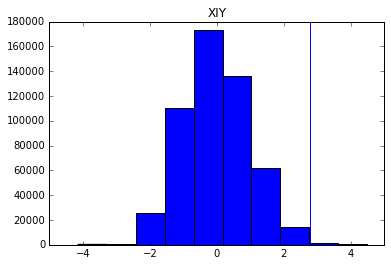

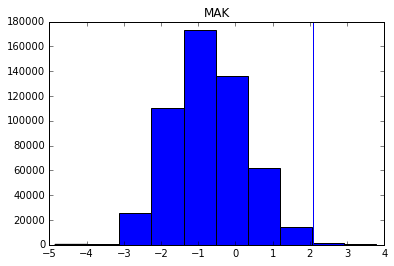

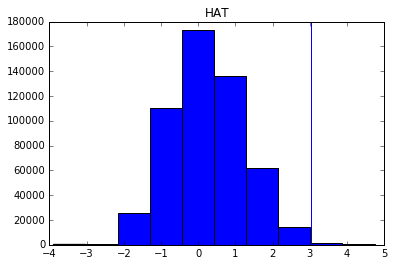

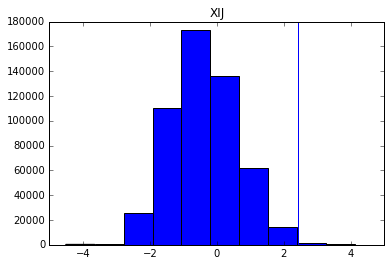

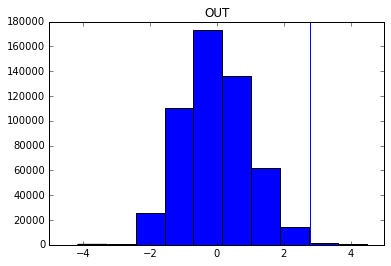

In [376]:
import pickle,os
train_path='all_data/'
all_speaker=get_all_speaker(train_path)
pitch_path='procd_pitch_newtrim/'
#print onlyfiles
pickle_file='spk_mean_dict.p'
spk_mean_dict={}
for speaker in all_speaker:
    #working with one speaker
    if os.path.isfile(pickle_file):
        spk_mean_dict=pickle.load(open(pickle_file,'rb'))
        print 'loading speaker mean...'
        spk_mean=spk_mean_dict[speaker]
    else:
        
        all_pitch,spk_mean=get_speaker_mean(speaker,pitch_path)
        print speaker+'mean:'+str(spk_mean)
        spk_mean_dict[speaker]=spk_mean
    all_pitch_norm=(np.log2(all_pitch)-np.log2(spk_mean))/np.std(np.log2(all_pitch))
    #print spk_mean
    #normalize,log,downsample,smooth
    #test with a file of this speaker
    #in a real situation, you'll get all files of the speaker, and call normalize and save them one by one.
    plt.figure()
    plt.hist(all_pitch_norm)
    plt.title(speaker)
    plt.axvline(x=np.percentile(all_pitch_norm,99.5))
    
pickle.dump(spk_mean_dict, open( pickle_file, "wb" ) )


the current next step is to apply different percentile cutoff and observe the results.(by plotting the overall long_ts)

In [369]:
spk_mean_dict

{'OUT': 6.9046678645777595}

In [67]:
0.2*1e7

2000000.0

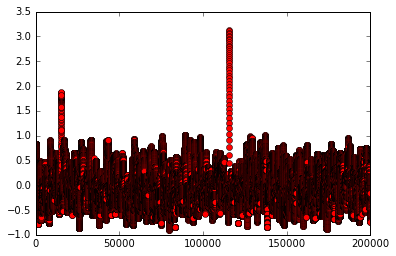

In [69]:
plt.plot(lts[2000000-100000:2000000+100000],'ro')

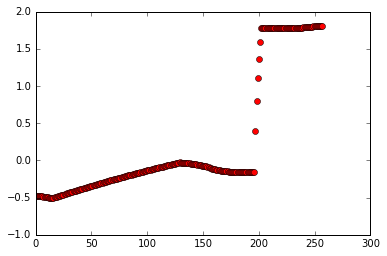

In [82]:
plt.plot(lts[1915200:1915458],'ro')

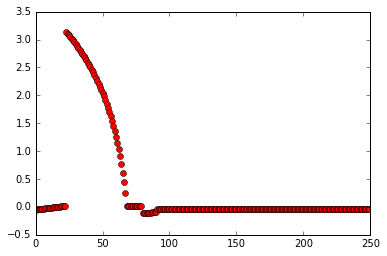

In [127]:
plt.plot(lts[2015250:2015500],'ro')

### interjected version var len

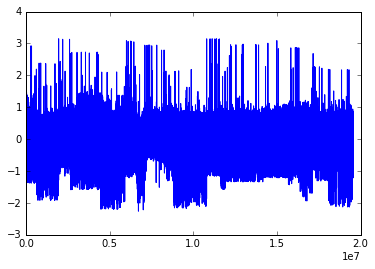

In [13]:
plt.plot(ltsj)

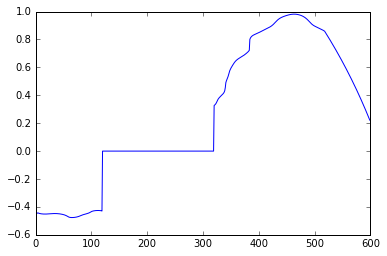

In [18]:
plt.plot(ltsj[2800:3400])

# building dict for indexing recovery

In [ ]:
#take a tab file, and get its lower and upper index; keep an overall counter of index. 
#using the tuple (lower,upper) as the key and attributes as the value - a strategy more consistent with our intent.
sent_path='norm_pitch/'
total_index=0

onlyfiles = [ f for f in listdir(sent_path) if f.endswith(".tab")]
print onlyfiles
for filename in onlyfiles:
    

<h3 style='background:blue; color:white; padding:5pt;'> below: starting to investigate the incorrect trimming problem</h3>

this problem was initiated by this example:
    

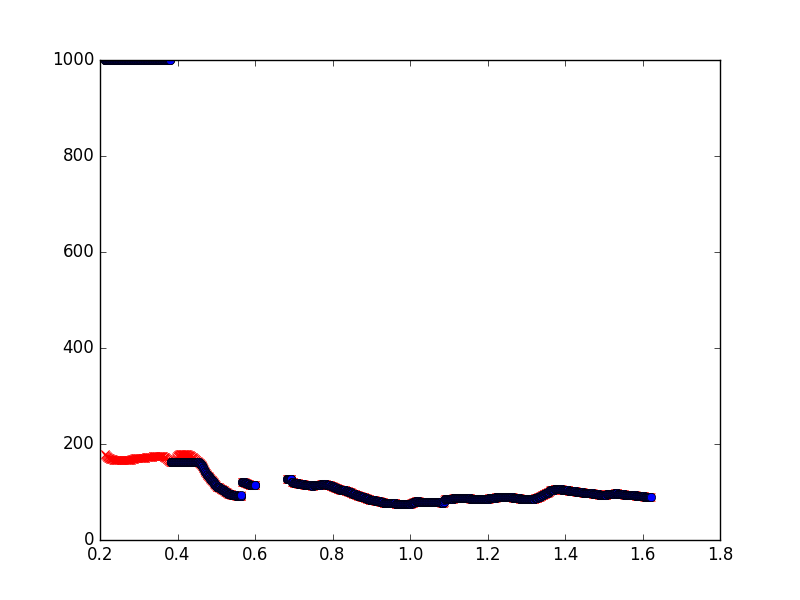

In [230]:
from IPython.display import Image#SUC000117
Image(filename='trim-prob.png') 

The problem is that in the earliest trimming stage, what is shown in red shouldn't be trimmed off but it is, leading to an extrapolation at 1000HZ(shows up in blue/black on the top in the beginning), and later when doing interpolation leading to a series of values from 1000 down to 200 hertz. As can be seen in the plots of long-ts (very beginning), this phenomenon is serious and occurs a lot. An inspection of the n-grams also reveals it affected those data as well.

This particular case is solved by strategy 2: threshold on std value. Below threshold, no trimming.

# correct the incorrect interpolation to 1000 problem

In [268]:

inputfile='pitch/pitcSUC000117.tab'
inputfile='pitch/pitcDIL000092.tab'
#inputfile='pitch/pitcDIL000153.tab'
inputfile='pitch/pitcHAT000051.tab'
f=open(inputfile,'r').read().split('\n')

time=[]
pitch=[]
for i in range(1,len(f)):
    line=f[i]
    if line!="":
        split=line.split('\t')
        #print split
        time.append(float(split[0]))
        pitch.append(float(split[1]))


B=plt.boxplot(pitch)
#plt.savefig(inputfile+'box.pdf')
plt.close() 
ydata=[item.get_ydata() for item in B['whiskers']]
upper=ydata[1][1] #this is the upper whisker

new_pitch=[]
new_time=[]
for i in range(len(pitch)):
    if pitch[i]<=upper:
        new_pitch.append(pitch[i])
        new_time.append(time[i])

adjusted_time=[i for i in time if i<=new_time[-1]]



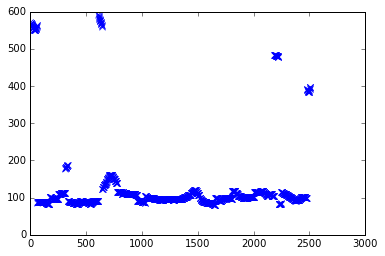

In [270]:
#HAT000051
plt.plot(pitch,'x')

{'boxes': [<matplotlib.lines.Line2D at 0x14d295250>],
 'caps': [<matplotlib.lines.Line2D at 0x14d2a2190>,
 'fliers': [<matplotlib.lines.Line2D at 0x14d2ac490>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x14d2a2e10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x14d295450>,
  <matplotlib.lines.Line2D at 0x14d295b10>]}

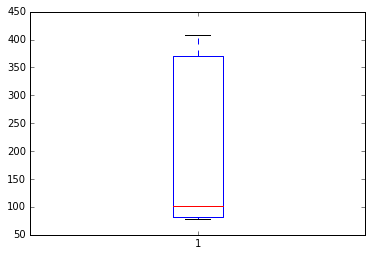

In [88]:
plt.boxplot(pitch)#DIL000092

{'boxes': [<matplotlib.lines.Line2D at 0x1927f75d0>],
 'caps': [<matplotlib.lines.Line2D at 0x192805510>,
 'fliers': [<matplotlib.lines.Line2D at 0x192812810>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1928121d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1927f77d0>,
  <matplotlib.lines.Line2D at 0x1927f7e90>]}

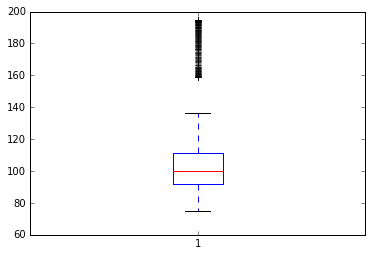

In [129]:
plt.boxplot(pitch)#DIL000153

In [84]:
print new_time[:10],new_time[-10:]
print adjusted_time[:10],adjusted_time[-10:]

[0.32599999999999996, 0.32699999999999996, 0.32799999999999996, 0.32899999999999996, 0.32999999999999996, 0.33099999999999996, 0.33199999999999996, 0.33299999999999996, 0.33399999999999996, 0.33499999999999996] [1.139, 1.1400000000000001, 1.141, 1.1420000000000001, 1.143, 1.1440000000000001, 1.145, 1.1460000000000001, 1.147, 1.1480000000000001]
[0.32599999999999996, 0.32699999999999996, 0.32799999999999996, 0.32899999999999996, 0.32999999999999996, 0.33099999999999996, 0.33199999999999996, 0.33299999999999996, 0.33399999999999996, 0.33499999999999996] [1.139, 1.1400000000000001, 1.141, 1.1420000000000001, 1.143, 1.1440000000000001, 1.145, 1.1460000000000001, 1.147, 1.1480000000000001]


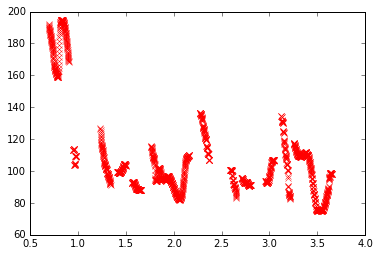

In [132]:
plt.plot(time,pitch,'rx')#DIL000153
#plt.plot(adjusted_time,new_pitch,'bx')

In [130]:
np.std(pitch)#DIL000153

28.70895088712243

In [133]:
upper#DIL000153

136.34350525411534

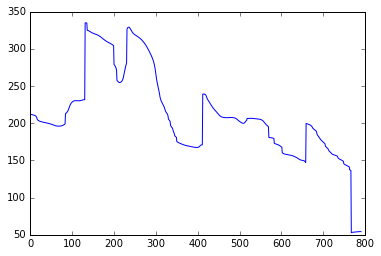

In [138]:
plt.plot(pitch)

in this above case DIL000092, the method of trimming didn't work because there are too few data points in the normal range to begin with so the spurious points are not treated different enough from most other normal points.

In another case SUC000117 and DIL000153, the method didn't work because the std of this pitch profile is too low, so that what's above the whisker is actually Ok pitch but nevertheless cut out.

### look at DIL000092 interpolation first then trim

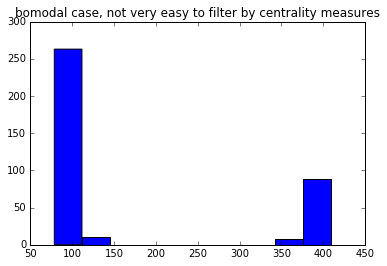

In [91]:
plt.hist(pitch)#DIL000092
plt.title('bomodal case, not very easy to filter by centrality measures')

<b> we should also do a contrast histogram after interpoloation</b> !!!

to remedy this, how about interpolate first, then trim?

to remedy for SUC, we can do a std estimation first and apply a threshold for trimming

as a last resort we can do a extrapolation at the mean value of the speaker.

In [107]:
from scipy.interpolate import interp1d
fp=interp1d(time,pitch,bounds_error=False, fill_value=200)
begin,end=time[0],time[-1]
interp_time=np.arange(float(begin),float(end),0.001)
pitch_new=interp_pitch=fp(interp_time)

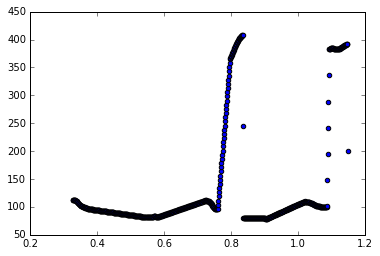

In [108]:
plt.scatter(interp_time,pitch_new)

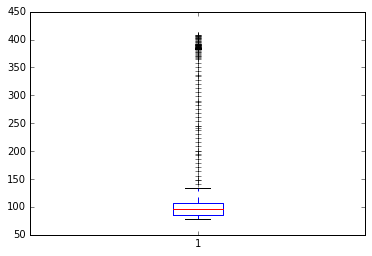

In [111]:
b=plt.boxplot(pitch_new)

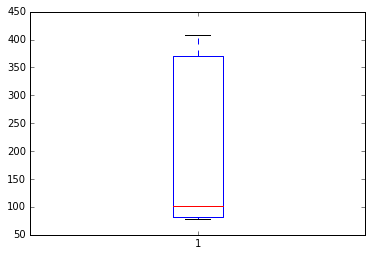

In [232]:
#above is the boxplot of new pitch distribution after doing interpolation first, in contrast to this one below 
#that shows original distribution
Image(filename='dil92.png') 

In [112]:
ydata=[item.get_ydata() for item in b['whiskers']]
upper=ydata[1][1] 
upper

133.68584623628124

originally the upper limit is at above 400 , as you can see above, so there is no chance to filter out the few pitch values at 400. But after we filled in with interpolation it is clear the upper bound is at 133, this is successfuilly filtering out all the spurious values. This also exploits a property of spurious values: the spurious pitch values are usually temporally rare events in the pitch contours. Therefore, filling the missing pitch points (reliable ones) at intermediate time stamps will help reveal that temporal structure and reveal the outliers.

In [113]:
new_pitch=[]
new_time=[]
for i in range(len(pitch)):
    if pitch[i]<=upper:
        new_pitch.append(pitch[i])
        new_time.append(time[i])

adjusted_time=[i for i in time if i<=new_time[-1]]

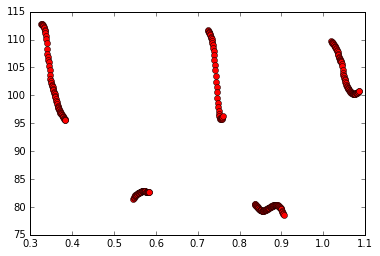

In [114]:
plt.plot(new_time,new_pitch,'ro')

this works.

### look at the distribution of standard diviations of pitch

how can we decide the threshold of a pitch profile's std for doing boxplot based cutoff?

In [168]:
from os import listdir
path='pitch/'
onlyfiles = [ f for f in listdir(path) if f.endswith(".tab")]
#all_std=[]
low_files=[]
low_sd=[]
low_time=[]
for filename in onlyfiles:
    inputfile=path+filename
    f=open(inputfile,'r').read().split('\n')

    pitch=[]
    time=[]
    for i in range(1,len(f)):
        
        line=f[i]
        if line!="":
            split=line.split('\t')
            #print split
            time.append(float(split[0]))
            pitch.append(float(split[1]))
    if np.std(pitch)<50:
        low_sd.append(pitch)
        low_files.append(filename)
        low_time.append(time)
    #all_std.append(np.std(pitch))


In [165]:
len(low_time)

3741

In [169]:
len(low_time[1874])

4115

In [136]:
len(low_sd)

3741

3002
std: 39.7397946382
std_interp: 40.4571494708
upper: 214.947383692
upper(new): 214.947383692


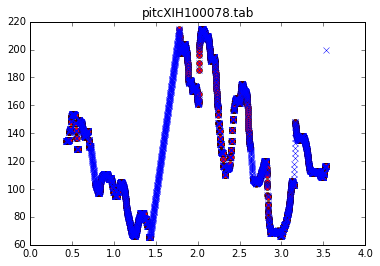

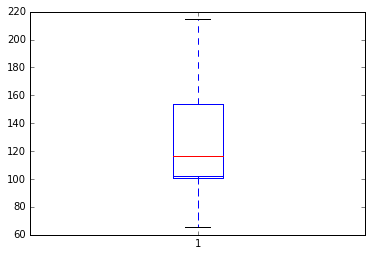

In [228]:
import random
rand=random.choice(range(len(low_sd)))
#rand=301
#rand=1874
#rand=3176
#rand=305
print rand


#two strageties: 1. do interploation first then use that to derive the upper bound, but still use the original 
#2. threshold filtering.


#do interpolation first
time=low_time[rand]
pitch=low_sd[rand]
fp=interp1d(time,pitch,bounds_error=False, fill_value=200)
begin,end=time[0],time[-1]
interp_time=np.arange(float(begin),float(end),0.001)
pitch_new=fp(interp_time)


print "std:", np.std(low_sd[rand])
plt.plot(low_time[rand],low_sd[rand],'ro')
#plt.plot(low_time[rand],low_sd[rand])
plt.plot(interp_time,pitch_new,'bx')
print 'std_interp:',np.std(pitch_new)

plt.title(low_files[rand])
plt.figure()
pitch=low_sd[rand]
B=plt.boxplot(pitch)
#plt.savefig(inputfile+'box.pdf')
#plt.close() 
ydata=[item.get_ydata() for item in B['whiskers']]
upper=ydata[1][1] #this is the upper whisker
print "upper:",upper

B=plt.boxplot(pitch_new)
#plt.savefig(inputfile+'box.pdf')
#plt.close() 
ydata=[item.get_ydata() for item in B['whiskers']]
upper=ydata[1][1] #this is the upper whisker
print "upper(new):",upper


#our goal is to see if in low std case, we could just not do the trimming based on whisker.and how low it should be. 
#presumbly if the std is high, then we need to do some trimming because there are likely more outliers.
#record: 1115, std=46, need trimming
#record: 1967, std=41, shouldn't have trimming
#2181, std=46, needs trimming
#305, std=26, but it needs trimming, tricky case

# conclusion on trmming correlated with std threshold

overall, I think std threshold of 45 is good. There are most of cases with low std there is no need for trimming. A recurrent motif in terms of needing of trimming is the last syllable of a sentence that often has no reliable pitch detection but just a short fragment of high pitch in the very end. This should be prune off, but there is no good way to recover what the real pitch track should be(up or down, or movement), so any extrapolation is not satisfactory. Therefore in this case instead of replacing the spurious pitch in the last syllable, I am going to leave it as is and it is possible there will be a motif discovered related to this that we can saftely discard. We'll keep an eye on this.


 we could also write this up

### next

- implement these two strategies in code. 
- make sure you plot the long ts and inspect it is ok.
- perform the entire preprocessing to generate data set again. 
- run MK-DB again on the new data sets.
- make long ts versions as planned.
- run MK-subsequence and MP.


<h3 style='background-color:blue;color:white;'> below is some earlier analysis</h3>

### look at 1874

In [155]:
newp=[i for i in pitch if i<328.78]

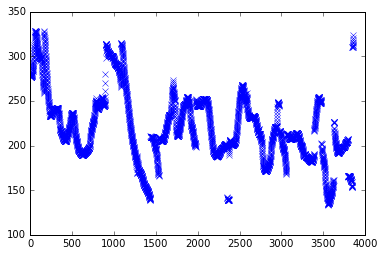

In [157]:
plt.plot(newp,'bx')

In [172]:
pitch=low_sd[rand]
B=plt.boxplot(pitch)
#plt.savefig(inputfile+'box.pdf')
plt.close() 
ydata=[item.get_ydata() for item in B['whiskers']]
upper=ydata[1][1] #this is the upper whisker
print upper

328.781990707


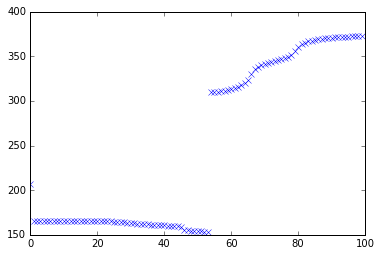

In [159]:
plt.plot(pitch[-100:],'x')

in this case, SHH000152, even though the std is pretty high, 48.74, we're unable to filter all spurious pitch since the upper whisker is at 329. Let's see if we can do better after doing interpolation first then attemp the trim.

In [173]:
time=low_time[1874]
fp=interp1d(time,pitch,bounds_error=False, fill_value=200)
begin,end=time[0],time[-1]
interp_time=np.arange(float(begin),float(end),0.001)
pitch_new=interp_pitch=fp(interp_time)

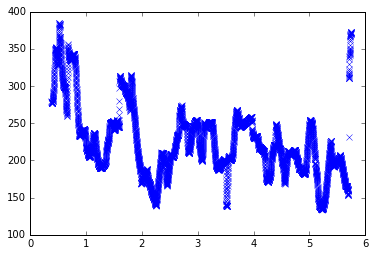

In [174]:
plt.plot(interp_time,pitch_new,'x')

In [176]:
#pitch=low_sd[rand]
B=plt.boxplot(pitch_new)
#plt.savefig(inputfile+'box.pdf')
plt.close() 
ydata=[item.get_ydata() for item in B['whiskers']]
upper=ydata[1][1] #this is the upper whisker
print upper

332.574114275


After the interpolation usually upper bound goes up. this represents a case that is very hard to get right because it is practically in the speaker's range.The only way is to hand correct this. But not everything has to be perfect - as long as we can do best to improve its accuracy. This should be part of the pitch evaluation because having high quality pitch contours is essential in our task. We can manually and formally evaluate many pitch tracks by plotting them. Then, later on we can also propose ways to find outliers in tone categories, and perhaps ways to prune off spurious pitch values by network analysis.

### look at distribution of all std values

In [62]:
len(all_std)

7849

(array([  631.,  2610.,  2365.,  1367.,   542.,   225.,    69.,    31.,
            6.,     3.]),
 array([   3.41662209,   24.66928276,   45.92194344,   67.17460411,
          88.42726479,  109.67992546,  130.93258614,  152.18524681,
         173.43790749,  194.69056816,  215.94322884]),
 <a list of 10 Patch objects>)

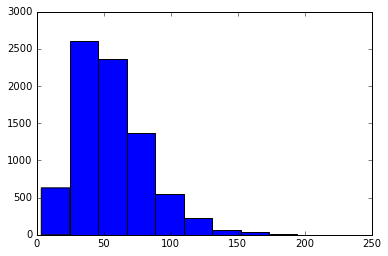

In [64]:
plt.hist(all_std)

{'boxes': [<matplotlib.lines.Line2D at 0x14ef41690>],
 'caps': [<matplotlib.lines.Line2D at 0x14ef725d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x14ef508d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x14ef50290>],
 'whiskers': [<matplotlib.lines.Line2D at 0x14ef41890>,
  <matplotlib.lines.Line2D at 0x14ef41f50>]}

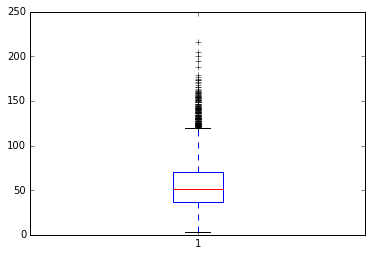

In [66]:
plt.boxplot(all_std)

# check some newly created pitch files after applying the two trim strategies

In [255]:
#inputfile='pitch/pitcDIL000153.tab'
#inputfile='norm_pitch_newtrim/DIL000092.tab'
def read_tab(inputfile):
    
    f=open(inputfile,'r').read().split('\n')

    time=[]
    pitch=[]
    for i in range(1,len(f)):
        line=f[i]
        if line!="":
            split=line.split('\t')
            #print split
            time.append(float(split[0]))
            pitch.append(float(split[1]))
    plt.plot(time,pitch,'rx')
    return time,pitch


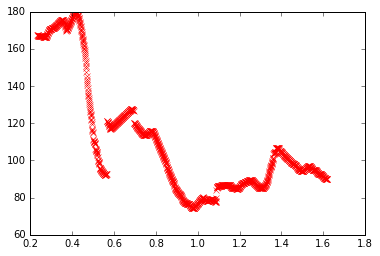

In [340]:
inputfile='procd_pitch_newtrim/SUC000117_proc.tab'

time,pitch=read_tab(inputfile)

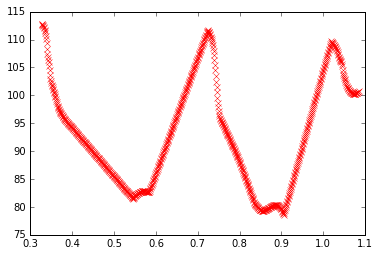

In [343]:
inputfile='procd_pitch_newtrim/DIL000092_proc.tab'

time,pitch=read_tab(inputfile)

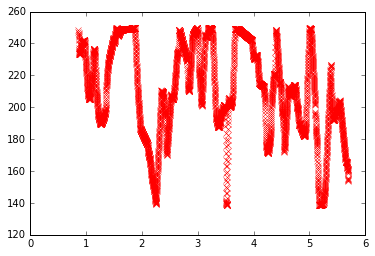

In [345]:
inputfile='procd_pitch_newtrim/SHH000152_proc.tab'

time,pitch=read_tab(inputfile)

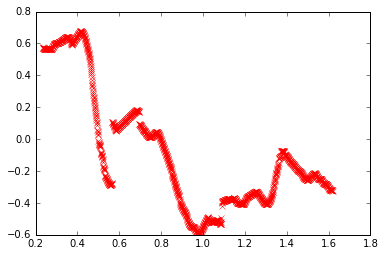

In [341]:
inputfile='norm_pitch_newtrim/SUC000117_norm.tab'

time,pitch=read_tab(inputfile)

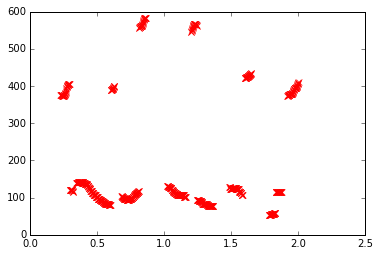

In [342]:
#ORIGINAL PITCH
inputfile='pitch/PITCHAT000056.tab'
time,pitch=read_tab(inputfile)

{'boxes': [<matplotlib.lines.Line2D at 0x21aff87d0>],
 'caps': [<matplotlib.lines.Line2D at 0x21afc3710>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d519aa10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1d519a3d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x21aff89d0>,
  <matplotlib.lines.Line2D at 0x21afc30d0>]}

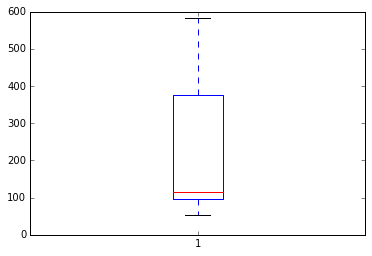

In [306]:
plt.boxplot(pitch)

In [302]:
np.std(pitch)

158.13654717009703

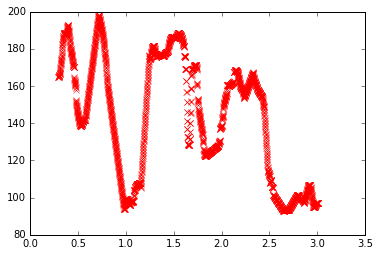

In [339]:
#AFTER TRIMMING AND UNVOICED FILETERING
inputfile='procd_pitch_newtrim/HAT000010_proc.tab'
time,pitch=read_tab(inputfile)

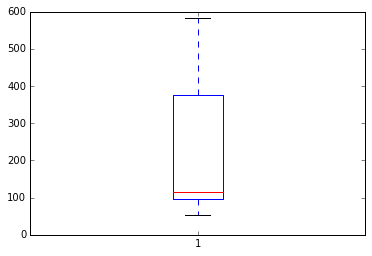

In [319]:
b=plt.boxplot(pitch)

In [310]:
b

{'boxes': [<matplotlib.lines.Line2D at 0x21b10a290>],
 'caps': [<matplotlib.lines.Line2D at 0x21b1091d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x21b1254d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x21b109e50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x21b10a490>,
  <matplotlib.lines.Line2D at 0x21b10ab50>]}

In [321]:
ydata

[array([ 96.82442235,  54.1472451 ]), array([ 375.53141207,  583.02464204])]

In [322]:
ydata=[item.get_ydata() for item in b['whiskers']]

upper=ydata[1][0]
new_pitch=[]
new_time=[]
for i in range(len(pitch)):
    if pitch[i]<=upper:
        new_pitch.append(pitch[i])
        new_time.append(time[i])



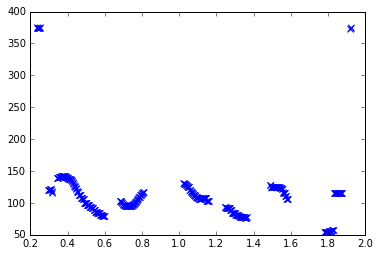

In [323]:
plt.plot(new_time,new_pitch,'x')

In [324]:
fp=interp1d(new_time,new_pitch,bounds_error=False, fill_value=200)
begin,end=new_time[0],new_time[-1]
interp_time=np.arange(float(begin),float(end),0.001)
pitch_new=interp_pitch=fp(interp_time)

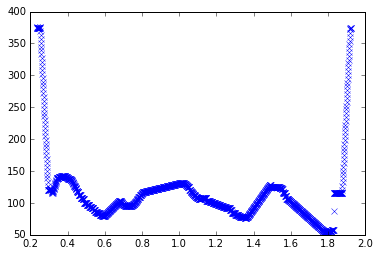

In [325]:
plt.plot(interp_time,pitch_new,'x')

168.752026141


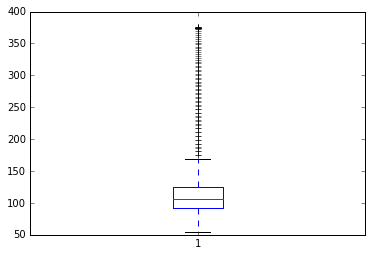

In [336]:
b=plt.boxplot(pitch_new)
ydata=[item.get_ydata() for item in b['whiskers']]

upper=ydata[1][1]
print upper
final_pitch=[]
final_time=[]
for i in range(len(pitch)):
    if pitch[i]<=upper:
        final_pitch.append(pitch[i])
        final_time.append(time[i])

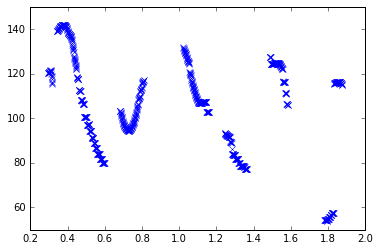

In [337]:
plt.plot(final_time,final_pitch,'x')

This is after we've get rid of extrapolation problems, a new problem we have found that rendered out first strategy of doing interpolation first and then filtering out spurious values less effective. The problem is that because spurious pitch can happen not only in the end or beginning but can be present all over in the middle. In that case, the interpolated version will bring in more spurious values and will not restore or recover the underlying correct structure and derive a wrong upper bound. Therefore what we do is to use the third quartile as a first upper limit to filter out things before we interpolate, then we interpolate and calculate the real upper bound (which is hopefully low enough), then we do as before : just filter time and pitch by this upper bound.

In [327]:
print upper

124.251683558


In [304]:
np.std(pitch)

151.58640967866836

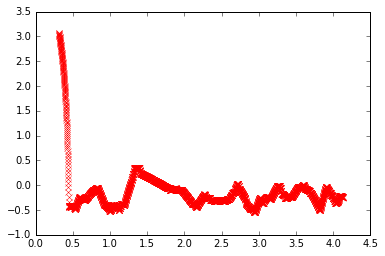

In [271]:
#AFTER NORMALIZATION AND LOGGING. 
inputfile='norm_pitch_newtrim/HAT000051_norm.tab'
time,pitch=read_tab(inputfile)

In [ ]:
#IN THESE THREE STEPS, STILL WE ARE LOOKING AT SECOND STEP THAT GOES WRONG. IT DOES SEEM THE SPURIOUS PITCH VALUES WERE
#SUCCESFULLY TRIMMED OFF.

In [286]:
#LET's see what happend after trimming
pitch_std=np.std(pitch)
if pitch_std>45:
    fp=interp1d(time,pitch,bounds_error=False, fill_value=0)
    begin,end=time[0],time[-1]
    interp_time=np.arange(float(begin),float(end),0.001)
    pitch_new=interp_pitch=fp(interp_time)
    B=plt.boxplot(pitch_new)
    #plt.savefig(inputfile+'box.pdf')
    plt.close() 
    ydata=[item.get_ydata() for item in B['whiskers']]
    upper=ydata[1][1] #this is the upper whisker

    new_pitch=[]
    new_time=[]
    for i in range(len(pitch)):
        if pitch[i]<=upper:
            new_pitch.append(pitch[i])
            new_time.append(time[i])

    adjusted_time=[i for i in time if i<=new_time[-1]]

    #plt.plot(new_time,new_pitch)
    fp=interp1d(new_time,new_pitch,bounds_error=False, fill_value=1000)
    trimmed_pitch=fp(adjusted_time)
else:
    adjusted_time,trimmed_pitch=time,pitch

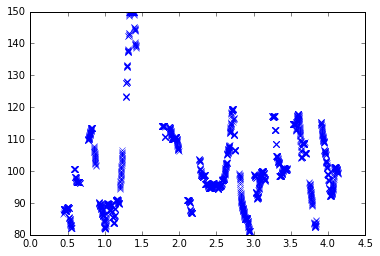

In [287]:
plt.plot(adjusted_time,trimmed_pitch,'x')

In [284]:
np.log(np.NAN)

nan